In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
from tqdm import tqdm
import numpy as np
from PIL import Image
import os
import pickle
import json
import cv2
import re
import keras

Using TensorFlow backend.


In [2]:
from keras import backend as K
K.tensorflow_backend._get_available_gpus()

['/job:localhost/replica:0/task:0/device:GPU:0']

In [9]:
# make image dataloader using flow_from_dataframe
import pandas as pd
from keras.preprocessing.image import ImageDataGenerator

# load data to extract labels
data_dir = 'mmhs150k/'
model_dir = 'models/'
tweet_dict = json.load(open(data_dir + 'MMHS150K_GT.json', 'r'))

# read split id's and return data generator
def get_data_dict(path):
    
    # build dictionary mapping id's to labels
    data = {'id': [], 'label': []}
    for id in open(data_dir + path, 'r').read().splitlines():

        # get majority vote label
        binary_labels = [1 if n > 0 else 0 for n in tweet_dict[id]['labels']]
        label = 1 if sum(binary_labels)/len(tweet_dict[id]['labels']) > 0.5 else 0

        # save to data dict
        data['id'].append(id + '.jpg')
        data['label'].append(str(label))
        
    data_df = pd.DataFrame.from_dict(data) # get dataframe to flow from
    
    datagen = ImageDataGenerator(rescale=1./255,
                                 samplewise_center=True,
                                 samplewise_std_normalization=True,
                                 width_shift_range=0.3,
                                 height_shift_range=0.3,
                                 shear_range=10,
                                 horizontal_flip=True,
                                 vertical_flip=True)
    datagen = ImageDataGenerator(rescale=1./255)
    generator = datagen.flow_from_dataframe(
        dataframe=data_df,
        directory=data_dir + 'img_resized',
        x_col='id',
        y_col='label',
        target_size=(299, 299),
        batch_size=16,
        class_mode='binary')
    
    return generator

train_generator = get_data_dict('splits/train_ids.txt')
val_generator = get_data_dict('splits/val_ids.txt')
test_generator = get_data_dict('splits/test_ids.txt')

Found 134823 validated image filenames belonging to 2 classes.
Found 5000 validated image filenames belonging to 2 classes.
Found 10000 validated image filenames belonging to 2 classes.


In [4]:
from keras.applications.inception_v3 import InceptionV3
from keras.optimizers import Adam
from keras.models import Sequential, Model
from keras.layers.core import Dense, Flatten

conv_base = keras.applications.inception_v3.InceptionV3(include_top=False, 
                                                        weights='imagenet', 
                                                        input_shape=(299, 299, 3))
for layer in conv_base.layers[:-1]: layer.trainable = False # freeze pretrained layers

model = Sequential()
model.add(conv_base)
model.add(Flatten())
# model.add(Dense(2048, activation='relu'))
model.add(Dense(1024, activation='relu'))
model.add(Dense(512, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
print(model.summary())

optimizer = Adam(lr = 0.001)
model.compile(loss="binary_crossentropy",optimizer=optimizer, metrics=['accuracy'])

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Model)         (None, 8, 8, 2048)        21802784  
_________________________________________________________________
flatten_1 (Flatten)          (None, 131072)            0         
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              134218752 
_________________________________________________________________
dense_2 (Dense)              (None, 512)               524800    
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 513       
Total params: 156,546,849
Trainable params: 134,744,065
Non-trainable params: 21,802,784
_________________________________________________________________
None


In [5]:
# train model
history = model.fit_generator(train_generator, 
                    validation_data=val_generator,
                    shuffle=True,
                    epochs=1)


Epoch 1/1
8427/8427 [==============================] - 3464s 411ms/step - loss: 0.5828 - accuracy: 0.7767 - val_loss: 1.2121 - val_accuracy: 0.5002


In [6]:
# test
from sklearn.metrics import roc_auc_score, f1_score, precision_score, recall_score

y_test = test_generator.classes

# get AUROC
preds = model.predict(test_generator)
print('Test AUROC:', roc_auc_score(y_test, preds))

# get loss and acc
print('Test acc:', model.evaluate(test_generator)[1])

# get F1
preds[preds>0.5] = 1
preds[preds<=0.5] = 0
preds_bin = preds
print('Test F1:', f1_score(y_test, preds_bin, zero_division=1))
print('Test Precision:', precision_score(y_test, preds_bin, zero_division=1))
print('Test Recall:', recall_score(y_test, preds_bin, zero_division=1))

Test AUROC: 0.49999992
625/625 [==============================] - 193s 308ms/step
Test acc: 0.5
Test F1: 0.0
Test Precision: 1.0
Test Recall: 0.0


In [10]:
model.save(model_dir + 'CNN.h5')

In [7]:
# see fraction of positive examples
print(sum(train_generator.classes)/len(train_generator.classes))
print(sum(val_generator.classes)/len(val_generator.classes))
print(sum(test_generator.classes)/len(test_generator.classes))

0.21855321421419194
0.4998
0.5


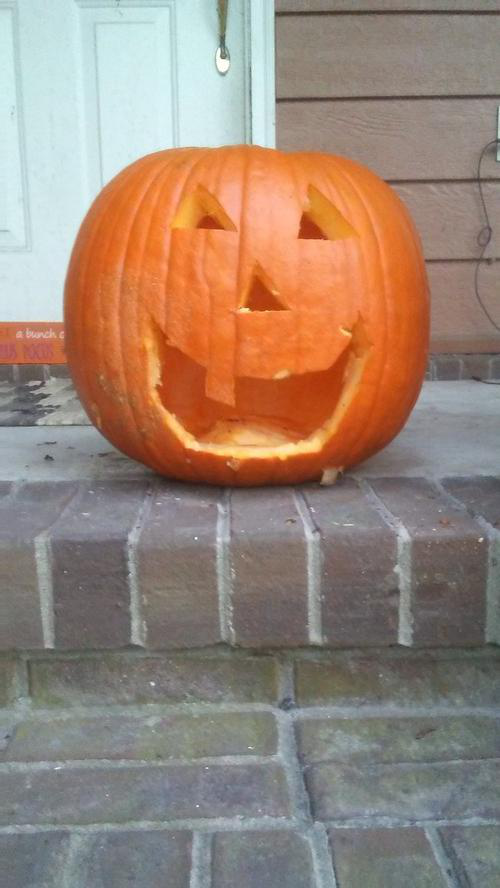

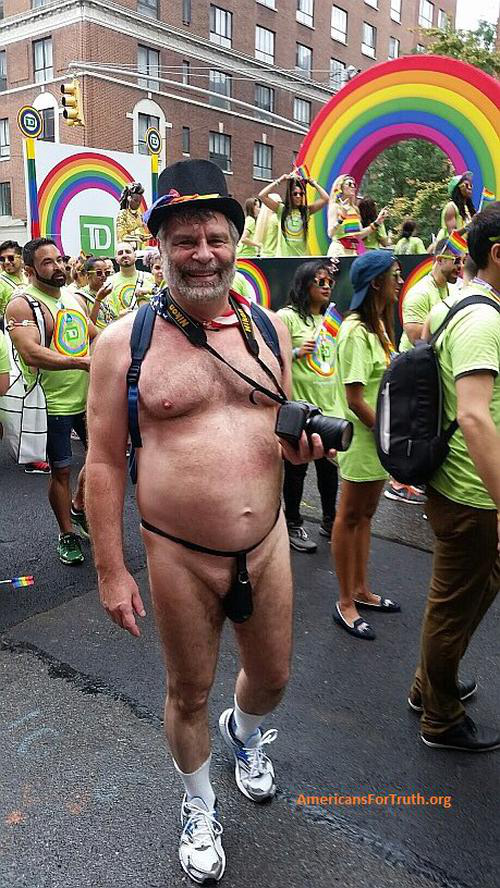

Found 2 validated image filenames belonging to 2 classes.


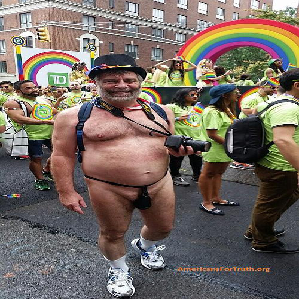

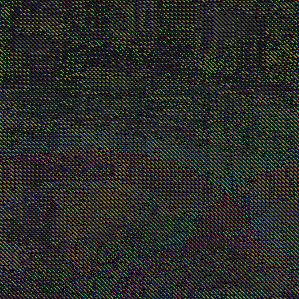

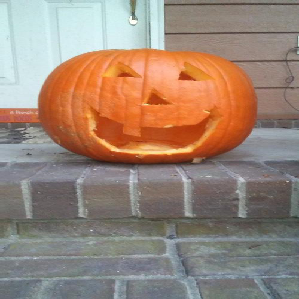

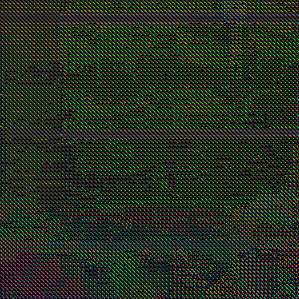

In [8]:
# make image dataloader using flow_from_dataframe
import pandas as pd
from keras.preprocessing.image import ImageDataGenerator

# load data to extract labels
data_dir = 'mmhs150k/'
tweet_dict = json.load(open(data_dir + 'MMHS150K_GT.json', 'r'))

# read split id's and return data generator
def get_data_dict(path):
    
    # build dictionary mapping id's to labels
    data = {'id': [], 'label': []}
    for id in open(data_dir + path, 'r').read().splitlines()[:2]: # test for two

        # get majority vote label
        binary_labels = [1 if n > 0 else 0 for n in tweet_dict[id]['labels']]
        label = 1 if sum(binary_labels)/len(tweet_dict[id]['labels']) > 0.5 else 0

        # save to data dict
        data['id'].append(id + '.jpg')
        data['label'].append("0" if not data['label'] else "1")
        
        im = Image.open(data_dir + 'img_resized/' + id + '.jpg')
        display(im)
        
        
    data_df = pd.DataFrame.from_dict(data) # get dataframe to flow from
    
    datagen = ImageDataGenerator()#rescale=1./255)
    generator = datagen.flow_from_dataframe(
        dataframe=data_df,
        directory=data_dir + 'img_resized',
        x_col='id',
        y_col='label',
        target_size=(299, 299),
        batch_size=2,
        class_mode='binary')
    
    return generator

train_generator = get_data_dict('splits/train_ids.txt')

# test image augmentation
x, y = train_generator.next()

# test image augmentation
for img, label in zip(x,y):
    im = Image.fromarray(np.uint8(img), 'RGB')
    display(im)
    im = Image.fromarray(img, 'RGB')
    display(im)